In [28]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [29]:
# ===== CNN Model Class (from training) =====
class CNNModel(nn.Module):
    def __init__(self, num_classes=38):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 54 * 54, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

In [30]:
# ===== Load Models Function =====
def load_model(model_path, model_type, num_classes=38):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if model_type == 'cnn':
        model = CNNModel(num_classes=num_classes)
    elif model_type == 'vgg':
        model = models.vgg16(pretrained=False)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif model_type == 'resnet':
        model = models.resnet18(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    else:
        raise ValueError("Unknown model type")

In [86]:
def load_model(model_path, model_type, num_classes=38):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if model_type == 'cnn':
        model = CNNModel(num_classes=num_classes)
        state_dict = torch.load(model_path, map_location='cpu')
        model.load_state_dict(state_dict)
    
    elif model_type == 'vgg':
        # Load base VGG16 architecture
        model = models.vgg16(pretrained=False)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

        # Load state dict from checkpoint
        state_dict = torch.load(model_path, map_location='cpu')

        # Filter only matching keys from the features part (ignore classifier)
        model_dict = model.state_dict()
        filtered_dict = {k: v for k, v in state_dict.items() if k in model_dict and v.size() == model_dict[k].size()}
        model_dict.update(filtered_dict)
        model.load_state_dict(model_dict)
    
    elif model_type == 'resnet':
    # Load checkpoint
        state_dict = torch.load(model_path, map_location='cpu')

        # Determine ResNet depth by layer4 size
        if any('layer4.0.downsample.1.weight' in k and v.shape[0] == 2048 for k, v in state_dict.items()):
            print("🧠 Detected ResNet50/101 based on state_dict.")
            model = models.resnet50(pretrained=False)
        else:
            print("🧠 Detected ResNet18/34 based on state_dict.")
            model = models.resnet18(pretrained=False)

        # Replace final layer
        model.fc = nn.Linear(model.fc.in_features, num_classes)

        # Filter state dict to load only matching keys
        model_dict = model.state_dict()
        filtered_dict = {k: v for k, v in state_dict.items() if k in model_dict and v.shape == model_dict[k].shape}
        model_dict.update(filtered_dict)
        model.load_state_dict(model_dict)

    else:
        raise ValueError("Unknown model type")

    model = model.to(device)
    model.eval()
    return model



In [87]:
def get_dataloader(data_dir, input_type, batch_size=32):
    if input_type == 'color':
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])
    elif input_type == 'gray':
        transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])
    else:
        raise ValueError("Unknown input type")

    dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader, dataset

In [88]:
# ADD THIS ABOVE extract_features()
def get_layer_output(model, x, layer_name):
    outputs = {}

    def hook(module, input, output):
        outputs['feat'] = output

    # Attach the hook to the specified layer
    for name, module in model.named_modules():
        if name == layer_name:
            handle = module.register_forward_hook(hook)
            break
    else:
        raise ValueError(f"Layer {layer_name} not found in model")

    _ = model(x)  # Forward pass
    handle.remove()  # Remove the hook

    return outputs['feat']

def extract_features(model, dataloader, layer_name, device='cpu'):
    model.eval()
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            
            # Forward pass up to layer_name, your existing code here:
            features = get_layer_output(model, images, layer_name)  # Make sure this returns tensor with batch dim

            # Flatten features per sample
            features = features.view(features.size(0), -1)

            all_features.append(features.cpu())
            all_labels.append(labels.cpu())

    # Concatenate all batches
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    return all_features, all_labels


In [89]:
# ===== KMeans Clustering and Metrics =====
def run_kmeans(features, labels, k_values):
    results = {}
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        pred_clusters = kmeans.fit_predict(features)

        ari = adjusted_rand_score(labels, pred_clusters)
        nmi = normalized_mutual_info_score(labels, pred_clusters)

        results[k] = {'ARI': ari, 'NMI': nmi}
        print(f"K={k} | ARI={ari:.4f} | NMI={nmi:.4f}")
    return results

In [91]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(features, labels, title):
    print("Applying PCA to reduce dimensionality before t-SNE...")

    n_components = min(30, features.shape[0], features.shape[1])
    pca = PCA(n_components=min(30, features.shape[0]))
    reduced_features = pca.fit_transform(features)

    print("Running t-SNE on PCA-reduced features...")
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(reduced_features)

    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='tab20', s=15)
    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.colorbar()
    plt.show()




🚀 Processing model: cnn_color


C:\Users\DSUCSCL7-22\AppData\Local\Temp\ipykernel_12212\2521716754.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location='cpu'

Model: cnn_color
Features shape: torch.Size([33, 760384])
Number of samples: 33
Labels shape: torch.Size([33])
K=10 | ARI=0.1663 | NMI=0.5229
K=20 | ARI=0.1204 | NMI=0.6430
Applying PCA to reduce dimensionality before t-SNE...
Running t-SNE on PCA-reduced features...


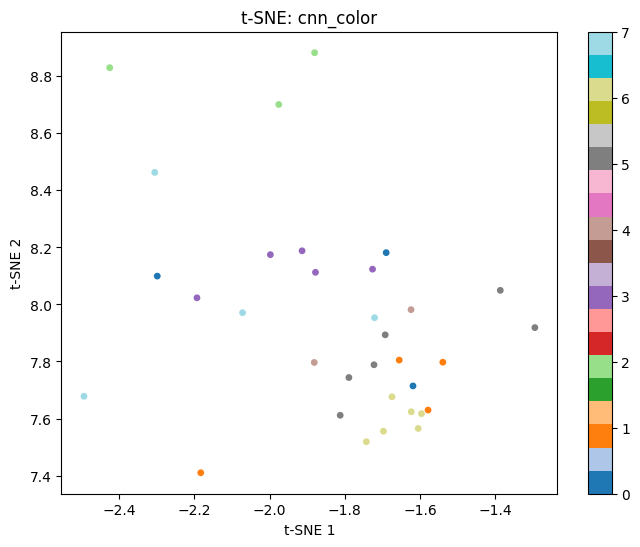


🚀 Processing model: cnn_gray


C:\Users\DSUCSCL7-22\AppData\Local\Temp\ipykernel_12212\2521716754.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location='cpu'

Model: cnn_gray
Features shape: torch.Size([33, 760384])
Number of samples: 33
Labels shape: torch.Size([33])
K=10 | ARI=0.1185 | NMI=0.4941
K=20 | ARI=0.1026 | NMI=0.6415
Applying PCA to reduce dimensionality before t-SNE...
Running t-SNE on PCA-reduced features...


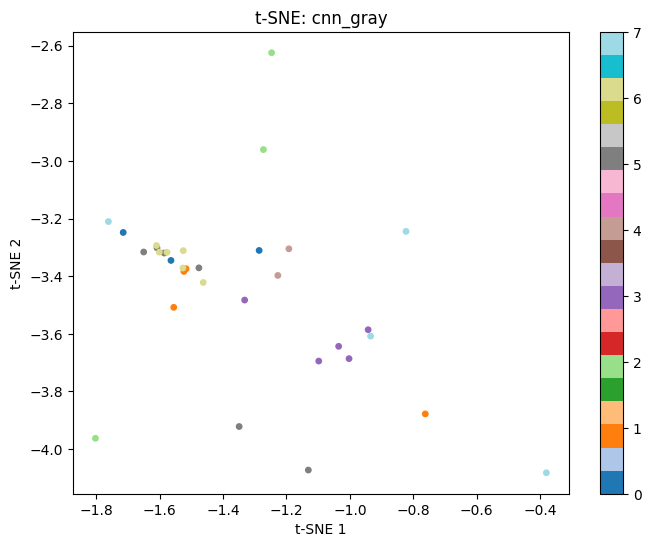


🚀 Processing model: vgg_color


C:\Users\DSUCSCL7-22\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DSUCSCL7-22\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\DSUCSCL7-22\AppData\Local\Temp\ipykernel_12212\2521716754.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will 

Model: vgg_color
Features shape: torch.Size([33, 100352])
Number of samples: 33
Labels shape: torch.Size([33])
K=10 | ARI=0.0606 | NMI=0.4982
K=20 | ARI=0.0848 | NMI=0.6432
Applying PCA to reduce dimensionality before t-SNE...
Running t-SNE on PCA-reduced features...


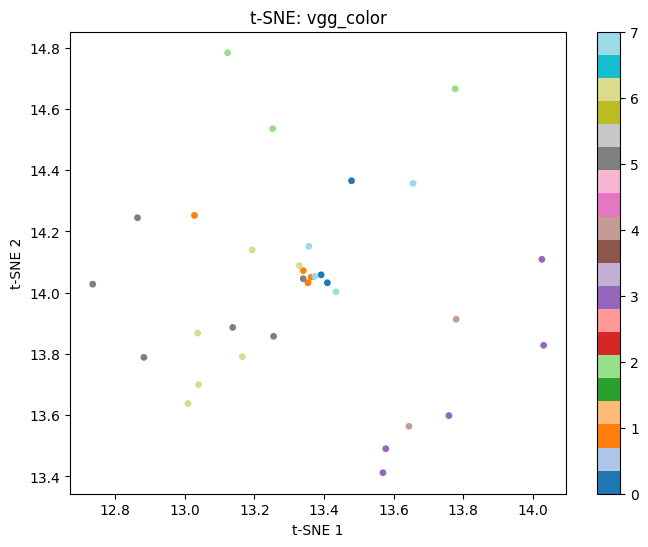


🚀 Processing model: vgg_gray


C:\Users\DSUCSCL7-22\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DSUCSCL7-22\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\DSUCSCL7-22\AppData\Local\Temp\ipykernel_12212\2521716754.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will 

Model: vgg_gray
Features shape: torch.Size([33, 100352])
Number of samples: 33
Labels shape: torch.Size([33])
K=10 | ARI=0.0998 | NMI=0.5163
K=20 | ARI=0.0246 | NMI=0.6132
Applying PCA to reduce dimensionality before t-SNE...
Running t-SNE on PCA-reduced features...


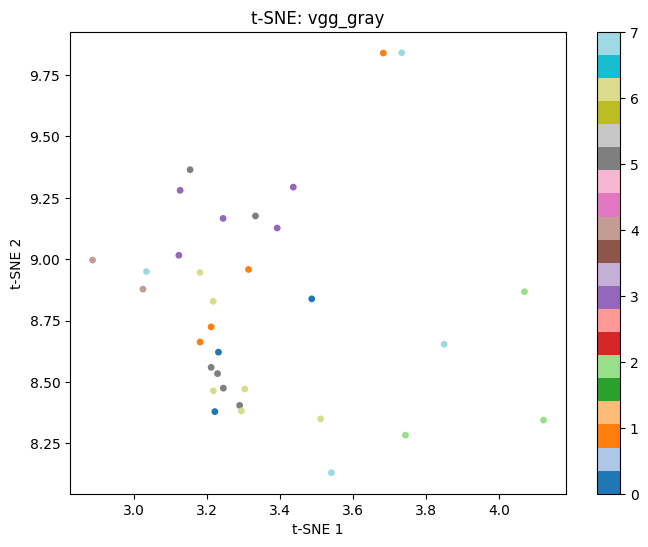


🚀 Processing model: resnet_color
🧠 Detected ResNet50/101 based on state_dict.


C:\Users\DSUCSCL7-22\AppData\Local\Temp\ipykernel_12212\2521716754.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location='cpu

Model: resnet_color
Features shape: torch.Size([33, 100352])
Number of samples: 33
Labels shape: torch.Size([33])
K=10 | ARI=0.1078 | NMI=0.5229
K=20 | ARI=0.1767 | NMI=0.7054
Applying PCA to reduce dimensionality before t-SNE...
Running t-SNE on PCA-reduced features...


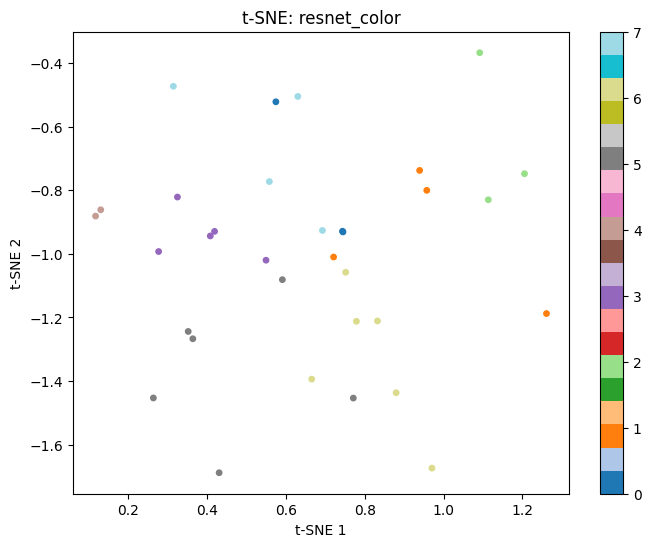


🚀 Processing model: resnet_gray
🧠 Detected ResNet50/101 based on state_dict.


C:\Users\DSUCSCL7-22\AppData\Local\Temp\ipykernel_12212\2521716754.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location='cpu

Model: resnet_gray
Features shape: torch.Size([33, 100352])
Number of samples: 33
Labels shape: torch.Size([33])
K=10 | ARI=0.1671 | NMI=0.5470
K=20 | ARI=0.1583 | NMI=0.6811
Applying PCA to reduce dimensionality before t-SNE...
Running t-SNE on PCA-reduced features...


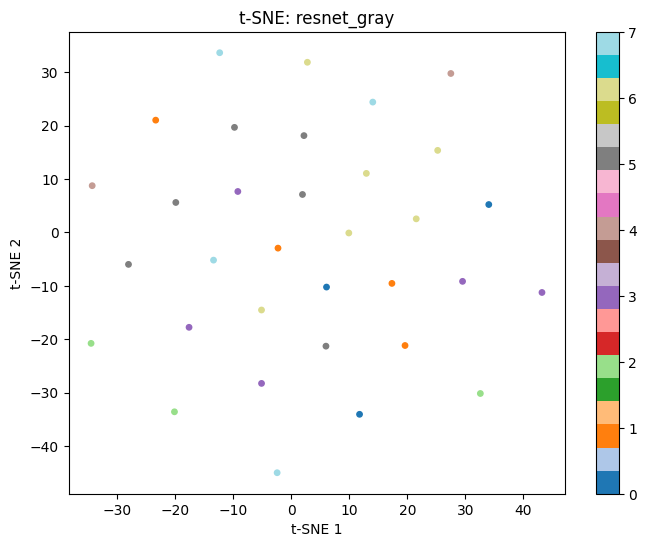


=== Clustering Summary (ARI and NMI) ===

Model: cnn_color
K=10 -> ARI: 0.1663, NMI: 0.5229
K=20 -> ARI: 0.1204, NMI: 0.6430

Model: cnn_gray
K=10 -> ARI: 0.1185, NMI: 0.4941
K=20 -> ARI: 0.1026, NMI: 0.6415

Model: vgg_color
K=10 -> ARI: 0.0606, NMI: 0.4982
K=20 -> ARI: 0.0848, NMI: 0.6432

Model: vgg_gray
K=10 -> ARI: 0.0998, NMI: 0.5163
K=20 -> ARI: 0.0246, NMI: 0.6132

Model: resnet_color
K=10 -> ARI: 0.1078, NMI: 0.5229
K=20 -> ARI: 0.1767, NMI: 0.7054

Model: resnet_gray
K=10 -> ARI: 0.1671, NMI: 0.5470
K=20 -> ARI: 0.1583, NMI: 0.6811


In [92]:
# ======= Configuration =======
layer_map = {
    'cnn': 'conv2',
    'vgg': 'features.28',
    'resnet': 'layer4'
}

model_info = [
    {"name": "cnn_color", "type": "cnn", "path": "models/best_cnn_color.pth"},
    {"name": "cnn_gray", "type": "cnn", "path": "models/cnn_grayscale.pth"},
    {"name": "vgg_color", "type": "vgg", "path": "models/best_vgg16_color_model.pth"},
    {"name": "vgg_gray", "type": "vgg", "path": "models/best_vgg16_gray_38class.pth"},
    {"name": "resnet_color", "type": "resnet", "path": "models/best_resnet_color_model.pth"},
    {"name": "resnet_gray", "type": "resnet", "path": "models/resnet_gray_best.pth"},
]

test_data_path = "test"  # Your root test directory

for info in model_info:
    print(f"\n🚀 Processing model: {info['name']}")
    
    model = load_model(info['path'], info['type'])
    input_type = 'gray' if 'gray' in info['name'] else 'color'
    
    # FIX: Use subfolder like test/test gray or test/test color
    subfolder = "test_gray" if input_type == "gray" else "test_color"
    data_path = os.path.join(test_data_path, subfolder)
    
    dataloader, dataset = get_dataloader(data_path, input_type)
    
    layer_name = layer_map[info['type']]
    features, labels = extract_features(model, dataloader, layer_name, device=device)
    if isinstance(features, torch.Tensor):
         features = features.view(features.size(0), -1)
    else:
         features = features.reshape(features.shape[0], -1)
 # Flatten from 4D to 2D
 # Add prints here to check shapes and number of samples
    print(f"Model: {info['name']}")
    print(f"Features shape: {features.shape}")
    print(f"Number of samples: {features.shape[0]}")
    print(f"Labels shape: {labels.shape}")
    valid_k_values = [k for k in k_values if k <= features.shape[0]]
    if not valid_k_values:
        print(f"⚠️ Skipping {info['name']} - not enough samples ({features.shape[0]}) for any k in {k_values}")
        continue

    # Run k-means only on valid k values
    clustering_results = run_kmeans(features, labels, valid_k_values)
    all_results[info['name']] = clustering_results


    plot_tsne(features, labels, title=f"t-SNE: {info['name']}")

# ======= Summary Report =======
print("\n=== Clustering Summary (ARI and NMI) ===")
for model_name, results in all_results.items():
    print(f"\nModel: {model_name}")
    for k, scores in results.items():
        print(f"K={k} -> ARI: {scores['ARI']:.4f}, NMI: {scores['NMI']:.4f}")